In [1]:
import sys 
import os 
import argparse 
import pprint

import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
from torch.utils.data import DataLoader
from haven import haven_utils as hu
from haven import haven_chk as hc

from src import datasets, models, wrappers
import exp_configs

In [2]:
exp_configs.EXP_GROUPS['loc']

[{'dataset': 'fish_loc',
  'task': 'loc',
  'model': 'unet',
  'batch_size': 1,
  'transform': 'rgb_normalize',
  'max_epoch': 500,
  'wrapper': 'loc_wrapper'},
 {'dataset': 'fish_loc',
  'task': 'loc',
  'model': 'fcn8',
  'batch_size': 1,
  'transform': 'rgb_normalize',
  'max_epoch': 500,
  'wrapper': 'loc_wrapper'}]

In [3]:
exp_dict = exp_configs.EXP_GROUPS['loc'][0]
savedir_base = "/home/kist-ubuntu/workspace_playground/DeepFish/outputs"

### Get experiment directory 

In [4]:
#exp_id = hu.hash_dict(exp_dict)
savedir = os.path.join(savedir_base, "trained_loc")
datadir = "/home/kist-ubuntu/workspace_playground/DeepFish/DeepFish"

In [5]:
print('Experiment saved in: %s' % savedir)

Experiment saved in: /home/kist-ubuntu/workspace_playground/DeepFish/outputs/trained_loc


### Set seed 

In [6]:
cuda = False

In [7]:
seed = 32 
np.random.seed(seed)
torch.manual_seed(seed)

if cuda: 
    device = "cuda"
    torch.cuda.manual_seed(seed)
    assert torch.cuda.is_available(), 'cuda is not, available please run with "-c 0"'
else: 
    device = 'cpu'
    
print('Running on device: %s' % device)

Running on device: cpu


### Dataset - Load val set and train

In [8]:
val_set = datasets.get_dataset(dataset_name=exp_dict["dataset"], split="val",
                                   transform=exp_dict.get("transform"),
                                   datadir=datadir)


val_loader = DataLoader(val_set, shuffle=False, batch_size=exp_dict["batch_size"])


In [9]:
image, labels, counts, points, meta = next(iter(val_loader)).values()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


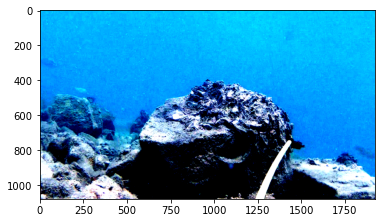

In [10]:
img = image.squeeze()
plt.imshow(img.permute(1,2,0))

In [11]:
print("Is there any fish?", labels)
print("How many?", counts)

Is there any fish? tensor([1.], dtype=torch.float64)
How many? tensor([3.], dtype=torch.float64)


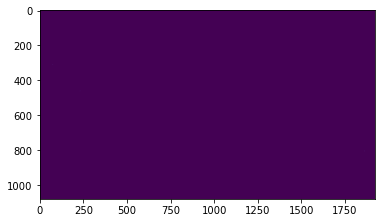

In [12]:
mask = points.squeeze()
plt.imshow(mask)

In [13]:
Y, X = np.where(mask>0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


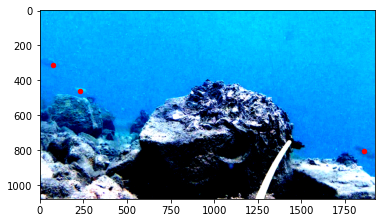

In [14]:
coordi = set(zip(Y,X))

plt.imshow(img.permute(1,2,0))

for j,i  in coordi: 
    plt.scatter(x=i, y=j, s=20, c='r')
        

In [15]:
set(coordi)

{(312, 73), (462, 229), (805, 1860)}

### Create model 

In [16]:
model_original = models.get_model(exp_dict["model"], exp_dict=exp_dict).to("cuda")

opt = torch.optim.Adam(model_original.parameters(), 
                        lr=1e-5, weight_decay=0.0005)

In [17]:
model = wrappers.get_wrapper(exp_dict['wrapper'], model=model_original, opt=opt).to("cuda")

In [18]:
model_path = os.path.join(savedir, "model_state_dict.pth")

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))                      

In [19]:
model.eval()

LocWrapper(
  (model): UNET(
    (inc): inconv(
      (conv): double_conv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
    (down1): down(
      (mpconv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): double_conv(
          (conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): ReLU(inplace=True)
          )
        )
      )
    )
    (down2): down(
      (mpconv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): double_conv(
          (conv

In [20]:
len(val_loader)

640

In [21]:
val_dict, pre_mask = model.val_on_batch(next(iter(val_loader)))

RuntimeError: Expected tensor for argument #1 'input' to have the same device as tensor for argument #2 'weight'; but device 0 does not equal 1 (while checking arguments for cudnn_convolution)

In [ ]:
val_dict

In [ ]:
np.where(pre_mask>0)

In [ ]:
pre_mask.max()